In [2]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'\\CHCFPP01\Guest\MRajabi\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import scipy
from matplotlib.gridspec import GridSpec
from mailmerge import MailMerge
import shutil
import openpyxl
from scipy.optimize import curve_fit
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-12-07 12:39:31


In [10]:
DB_Dir = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\9.0_IL_SafetyDB'
Project_Dir = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\IL_Crash_Assignment'
SourceDir = Project_Dir + '\\CrashData_Original'
OutputDir = Project_Dir + '\\CrashData_Cleaned'
GDB = Project_Dir + '\\IL_Crash.gdb'
Project_Dir = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\ILSHSP_Tables'
print(strftime("%Y-%m-%d %H:%M:%S"))
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-12-07 13:03:11
2018-12-07 13:03:11


In [5]:
#Read Crash Data
print(strftime("%Y-%m-%d %H:%M:%S"))
Crash_DF = pd.DataFrame()
Veh_DF = pd.DataFrame()
Occ_DF = pd.DataFrame()
for year in range(2005,2017):
    df = pd.read_csv(OutputDir+'\\{}_Crash_Joined.csv'.format(year),index_col=0,low_memory=False)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['YEAR'] = year
    Crash_DF = pd.concat([Crash_DF,df])
    df = pd.read_csv(OutputDir+'\\{}_Vehicle_Cleaned_EA.csv'.format(year),index_col=[0,1],low_memory=False)
    df['YEAR'] = year
    Veh_DF = pd.concat([Veh_DF,df])
    df = pd.read_csv(OutputDir+'\\{}_Person_Cleaned_EA.csv'.format(year),index_col=[0,1,2], encoding='latin-1',low_memory=False)
    df['DOB'] = pd.to_datetime(df['DOB'])
    df['YEAR'] = year
    Occ_DF = pd.concat([Occ_DF,df])
    print(year)
print(Crash_DF.shape,Veh_DF.shape,Occ_DF.shape)
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-12-07 12:39:47


C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (57,66,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
(4020749, 104) (6943650, 40) (9451580, 35)
2018-12-07 12:51:19


In [13]:
EADF = pd.read_excel(Project_Dir + '\\SourceData\EA_Definition.xlsx',index_col=0)
EADF = EADF.sort_index()
EADF['Order'] = [1,4,5,3,2,7,13,6,8,9,10,11,12,14]
EADF = EADF.sort_values('Order')
EADF['Priority'] = [1,1,1,1,2,2,2,2,2,2,3,3,3,3]
EADF = EADF.sort_index()
EADF.CrashDataField = ['EA_{}'.format(a) for a in EADF.Acronym]
EADF

,Acronym,Name,CrashDataField,Description,Order,Priority
ID,,,,,,
1,RD,Roadway Departure,EA_RD,A roadway departure crash is a crash in which ...,1,1
2,IN,Intersection Related,EA_IN,An intersection crash is defined by the respon...,4,1
3,SA,Speeding/Aggressive Driver,EA_SA,Speeding/aggressive driving are identified whe...,5,2
4,UO,Unrestrained Occupants,EA_UO,An unrestrained occupant crash is defined as a...,3,1
5,IM,Impaired Driver,EA_IM,Impaired driver crashes occur when at least on...,2,1
6,YD,Young Driver,EA_YD,Young driver crashes are defined as crashes in...,7,2
7,DF,Distracted/Fatigued/Drowsy,EA_DF,A distracted/fatigued/drowsy-driver-involved c...,13,3
8,OD,Older Driver,EA_OD,Older driver crashes are crashes involving at ...,6,2
9,MC,Motorcycle,EA_MC,A motorcycle-related crash is defined as a cra...,8,2


ValueError: Axis limits cannot be NaN or Inf

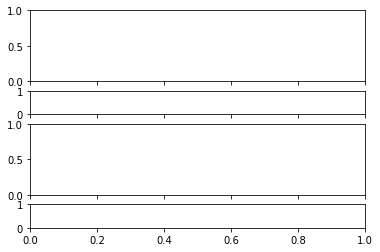

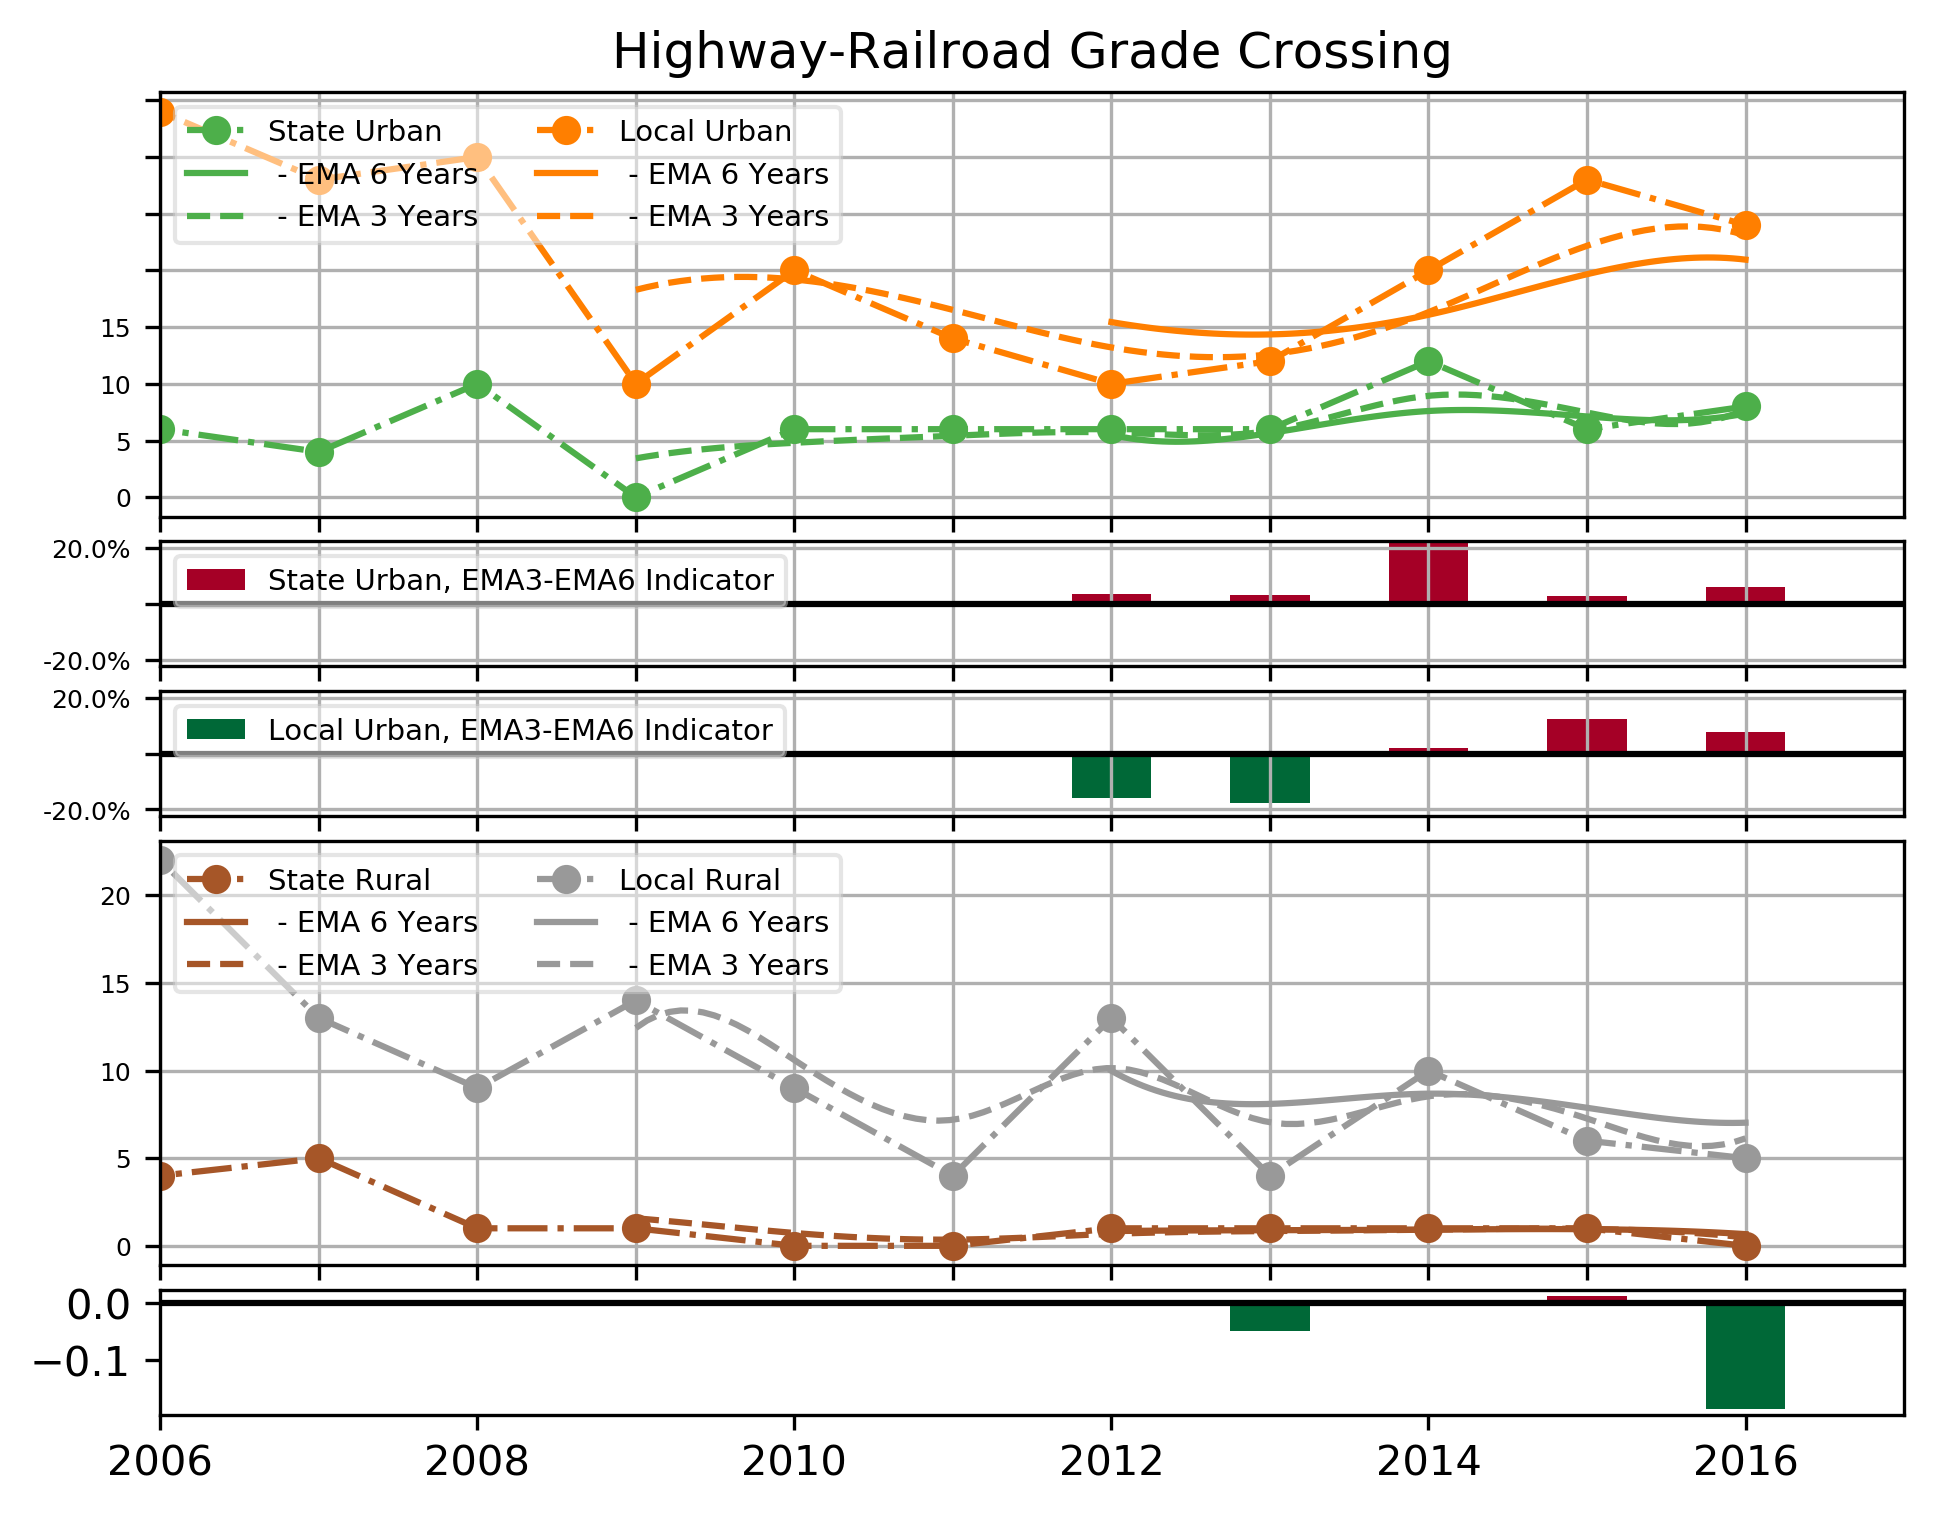

In [47]:
def Year_SLRU_EMA(Crash_DF,EADF,PNGName):
    import warnings
    warnings.filterwarnings('ignore')
    from scipy.optimize import curve_fit
    import matplotlib
    def LineFun(x, A, B):
            return A*x + B
    def EMA(Data,window):
        from scipy.interpolate import spline
        Data =Data.fillna(0)
        ema = pd.ewma(Data,span = window)[window-1:]
        #z = np.polyfit(ema.index, ema, 4)
        #f = np.poly1d(z)
        x = np.linspace(list(ema.index)[0], list(ema.index)[-1],100)
        try:
            y = spline(list(ema.index),ema,x)
            return(pd.Series(index=x,data=y))
        except:
            print(ema)
            return(pd.Series(index=x,data=0))
        #y = f(x)
    def Get_NM_EMA_Diff(Crash_EA_DF,SLUR):
                    cr = Crash_EA_DF[(Crash_EA_DF.State_Local_Urban_Rural==SLUR)].groupby(['Crash_Year'])['KA'].aggregate(sum)
                    cr.index = [2000+k for k in cr.index]
                    cr = cr.loc[range(2007,2017)]
                    cr = cr.fillna(0)
                    ema1 = pd.ewma(cr,span = 6)
                    ema2 = pd.ewma(cr,span = 3)
                    diff = ema2-ema1
                    diff = pd.Series([a/b for a,b in zip(diff.loc[diff.index[1:]],cr.loc[diff.index[:-1]])],index=range(2008,2017))
                    diff = diff.loc[range(2012,2017)]
                    return(diff)   
    my_cmap = matplotlib.cm.get_cmap('RdYlGn_r')
    my_norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    barwidth = 0.5
    CL = pd.DataFrame(data=[[plt.cm.Set1(0.9/4*(i+1))] for i in range(4)],index=['State Urban','Local Urban','State Rural','Local Rural'])
    for i,r in EADF.iterrows():
            df = pd.DataFrame(Crash_DF[Crash_DF[r.CrashDataField]==1].groupby(['Crash_Year','State_Local_Urban_Rural'])['KA'].aggregate(sum))
            df = df.unstack('State_Local_Urban_Rural')
            df.index = [2000+i for i in df.index]
            df.columns = [c[1] for c in df.columns]
            df = df.fillna(0)
            gs = matplotlib.gridspec.GridSpec(10, 1)
            n = len(df.columns)
            ic = 0
            M = list(matplotlib.markers.MarkerStyle.markers.keys())
            O = ['State Urban','Local Urban','State Rural','Local Rural']
            tPlot, axes = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[3,1,3,1]})
            plt.figure(figsize=(7.5, 6.5), dpi=300, facecolor='w', edgecolor='k')
            for j,l in enumerate(['Urban','Rural']):
                plt.subplot(gs[5*j:5*j+3, :])
                for l2 in ['State','Local']:
                    ic+=0.9/4
                    plt.plot(df.index,df[' '.join([l2,l])],'-.o',label=' '.join([l2,l]), color=CL.loc[' '.join([l2,l]),0])
                    for k,win in enumerate([6,3]):
                        cr = Crash_DF[(Crash_DF[r.CrashDataField]==1) & (Crash_DF.State_Local_Urban_Rural==' '.join([l2,l]))].groupby(['Crash_Year'])['KA'].aggregate(sum)
                        cr.index = [2000+k for k in cr.index]
                        cr = cr.fillna(0)
                        cr = cr.loc[range(2007,2017)]
                        #A,B = curve_fit(LineFun, cr.index, cr)[0]
                        plt.plot(EMA(cr,win),
                                 {0:'-',1:'--'}[k],
                                 color=CL.loc[' '.join([l2,l]),0],
                                 label=' - EMA {} Years'.format(win))
                plt.xlim(2006,2017)
                plt.xticks(range(2006,2017),[])
                yt = ['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]
                yt[0] = ''
                yt[-1] = ''
                plt.gca().set_yticklabels(yt)
                plt.tick_params(axis='both', which='major', labelsize=6)
                plt.tick_params(axis='both', which='minor', labelsize=6)
                plt.legend(loc='upper left',fancybox=True,framealpha=0.5, prop={'size': 7},ncol=2)
                plt.grid()
                if j==0:
                    plt.title(r.Name)
                plt.subplot(gs[5*j+3, :])
                l2  = 'State'
                #plt.gca().set_axis_bgcolor(CL.loc[' '.join([l2,l]),0])
                diff_S = Get_NM_EMA_Diff(Crash_DF[Crash_DF[r.CrashDataField]==1],' '.join(['State',l]))
                diff_L = Get_NM_EMA_Diff(Crash_DF[Crash_DF[r.CrashDataField]==1],' '.join(['Local',l]))
                L = [abs(v) for v in list(pd.concat([diff_S,diff_L]))]
                yl = [-max(L),max(L)]
                diff = diff_S
                plt.bar(diff.index,diff,align='center',color = my_cmap(np.sign(diff)),label='{} {}, EMA3-EMA6 Indicator'.format(l2,l),width=barwidth)
                plt.hlines(0,2006,2017,'black')
                plt.xlim(2006,2017)
                plt.ylim(yl[0],yl[1])
                plt.xticks(range(2006,2017),[])
                yt = ['{:,.1%}'.format(x) for x in plt.gca().get_yticks()]
                yt = [{True:y,False:''}[z in [1,len(yt)-2]] for z,y in enumerate(yt)]
                plt.gca().set_yticklabels(yt)
                plt.tick_params(axis='both', which='major', labelsize=6)
                plt.tick_params(axis='both', which='minor', labelsize=6)
                plt.grid()
                plt.legend(loc='upper left',fancybox=True,framealpha=0.5, prop={'size': 7},ncol=1)
                plt.subplot(gs[5*j+4, :])
                l2 = 'Local'
                #plt.gca().set_axis_bgcolor(CL.loc[' '.join([l2,l]),0])
                diff = diff_L
                plt.bar(diff.index,diff,align='center',color=my_cmap(np.sign(diff)),label='{} {}, EMA3-EMA6 Indicator'.format(l2,l),width=barwidth)
                plt.hlines(0,2006,2017,'black')
                plt.xlim(2006,2017)
                plt.ylim(yl[0],yl[1])
                plt.xticks(range(2006,2017),[])
                yt = ['{:,.1%}'.format(x) for x in plt.gca().get_yticks()]
                yt = [{True:y,False:''}[z in [1,len(yt)-2]] for z,y in enumerate(yt)]
                plt.gca().set_yticklabels(yt)
                plt.tick_params(axis='both', which='major', labelsize=6)
                plt.tick_params(axis='both', which='minor', labelsize=6)
                plt.grid()
                plt.legend(loc='upper left',fancybox=True,framealpha=0.5, prop={'size': 7},ncol=1)
            plt.xticks(df.index,df.index,rotation=0)
            plt.tight_layout()
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(PNGName(r.Name.replace('/','_').replace(' ','_')),transparent=True,DeprecationWarning=1200)
            plt.close()
            plt.close()
Year_SLRU_EMA(Occ_DF[Occ_DF.INJ_SEV.isin([3,4])],EADF,'58.{}_SLUR_EMA.png'.format)

In [40]:
Occ_DF['KA'] = [{True:1,False:0}[i in [3,4]] for i in Occ_DF.INJ_SEV]

In [45]:
def SLUR(JUR_TYPE,URBAN):
    if JUR_TYPE in [1]:
        s1 = 'State'
    elif JUR_TYPE in [7]:
        s1 = 'Private'
    else:
        s1 = 'Local'    
    if URBAN == 0:
        s2 = 'Rural'
    else:
        s2 = 'Urban'
    return('{} {}'.format(s1,s2))
Occ_DF['Crash_Year'] = Occ_DF.YEAR - 2000
#Crash_DF['State_Local_Urban_Rural'] = [SLUR(j,u) for j,u in zip(Crash_DF.JUR_TYPE,Crash_DF.URBAN)]
#Occ_DF['State_Local_Urban_Rural'] = pd.Series(list(Crash_DF.loc[Occ_DF.index.droplevel([1,2]),'State_Local_Urban_Rural']),
#                                              index=Occ_DF.index)

In [2]:
# Read All KABs from 2005 to 2016
print(strftime("%Y-%m-%d %H:%M:%S"))
K_Crash_DF = pd.read_csv('K_Crash_05_16.csv',index_col=0)
K_Veh_DF = pd.read_csv('K_Veh_05_16.csv',index_col=[0,1],low_memory=False)
K_Occ_DF = pd.read_csv('K_Occ_05_16.csv',index_col=[0,1,2], encoding='latin-1',low_memory=False)
print(K_Crash_DF.shape,K_Veh_DF.shape,K_Occ_DF.shape)
A_Crash_DF = pd.read_csv('A_Crash_05_16.csv',index_col=0)
A_Veh_DF = pd.read_csv('A_Veh_05_16.csv',index_col=[0,1],low_memory=False)
A_Occ_DF = pd.read_csv('A_Occ_05_16.csv',index_col=[0,1,2], encoding='latin-1',low_memory=False)
K_Crash_DF['DATE'] = pd.to_datetime(K_Crash_DF['DATE'])
A_Crash_DF['DATE'] = pd.to_datetime(A_Crash_DF['DATE'])
K_Occ_DF['DOB'] = pd.to_datetime(K_Occ_DF['DOB'])
A_Occ_DF['DOB'] = pd.to_datetime(A_Occ_DF['DOB'])
print(A_Crash_DF.shape,A_Veh_DF.shape,A_Occ_DF.shape)
B_Crash_DF = pd.read_csv('B_Crash_05_16.csv',index_col=0)
B_Veh_DF = pd.read_csv('B_Veh_05_16.csv',index_col=[0,1],low_memory=False)
B_Occ_DF = pd.read_csv('B_Occ_05_16.csv',index_col=[0,1,2], encoding='latin-1',low_memory=False)
B_Crash_DF['DATE'] = pd.to_datetime(B_Crash_DF['DATE'])
B_Occ_DF['DOB'] = pd.to_datetime(B_Occ_DF['DOB'])
print(B_Crash_DF.shape,B_Veh_DF.shape,B_Occ_DF.shape)
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-21 11:58:01
(11510, 56) (17049, 40) (29143, 35)
(126492, 56) (205139, 40) (334237, 35)
(367390, 56) (613650, 40) (987092, 35)
2018-11-21 11:58:55


In [ ]:
# Check Summations
print(strftime("%Y-%m-%d %H:%M:%S"))
display(K_Crash_DF.groupby(['YEAR'])['K','A','B','C','O'].aggregate(sum))
df1 = pd.DataFrame(K_Occ_DF.groupby(['YEAR','INJ_SEV']).size())
df1 = df1.unstack()
df1.columns = ['O','C','B','A','K']
df1 = df1[['K','A','B','C','O']]
display(df1)

In [4]:
def Ex_Unit(u):
        if u==1:
            return('Unit1')
        else:
            return('OtherUnits')
def Ex_PT(u):
        if u==1:
            return('Driver')
        elif u in [2,3]:
            return('Front Passenger')
        elif u==0:
            return('Unknown')
        else:
            return('BackSeat Passengers')
def Ex_SE(s):
        if s in [1,3,5,7,8]:
            return('Improper/Not Used')
        elif s in [9]:
            return('Unknown')
        else:
            return('Used')
def Ex_Domain(Codes,value):
        try:
            return(Codes[value])
        except:
            return('')
def Ex_BAC(v):
        if v<8:
            return('Less than 0.08%')
        elif v>=8 and v<95:
            return('More than 0.08%')
        elif v==95:
            return('Refused')
        elif v==96:
            return('Not Offered')
        elif v==97:
            return('Performed/Results Unknown')

In [39]:
# Filed Conversions
print(strftime("%Y-%m-%d %H:%M:%S"))
for df in [K_Occ_DF,A_Occ_DF,B_Occ_DF]:
    df['UID'] = list(df.index.droplevel([0,2]))
    df['Unit'] = [Ex_Unit(u) for u in df.UID]
    df['PersonType'] = [Ex_PT(p) for p in df.SEAT_POS]
    df['SafetyEq'] = [Ex_SE(s) for s in df.SAF_EQI]
    df['Ejection'] = [{1:'Not Ejected',2:'Ejected',3:'Ejected',4:'Trapped',9:'Not Ejected',0:'Not Ejected'}[e] for e in df.EJECT]
    for n,f in zip(['DrCondition','Severity'],['DR_CON','INJ_SEV']):
        df[n] = ['{:02}_{}'.format(s,Ex_Domain(getattr(hsmpy3.il.domains,f)['codes'],s)) for s in df[f]]
    df['BloodAlcohol'] = [Ex_BAC(v) for v in df.BAC]

for df in [K_Crash_DF,A_Crash_DF,B_Crash_DF]:
    for f in ['COL_TYPE']:
        df[f] = df[f].astype(int,errors="ignore")
    for n,f in zip(['CrashType'],['COL_TYPE']):
        df[n] = ['{}'.format(Ex_Domain(getattr(hsmpy3.il.domains,f)['codes'],s)) for s in df[f]]
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-21 12:27:33
2018-11-21 12:27:51


,January,February,March,April,May,June,July,August,September,October,November,December
SeasonalFactor,0.845432,0.755674,0.855217,0.917947,1.100941,1.062103,1.166309,1.165496,1.063514,1.084706,0.988241,0.99442


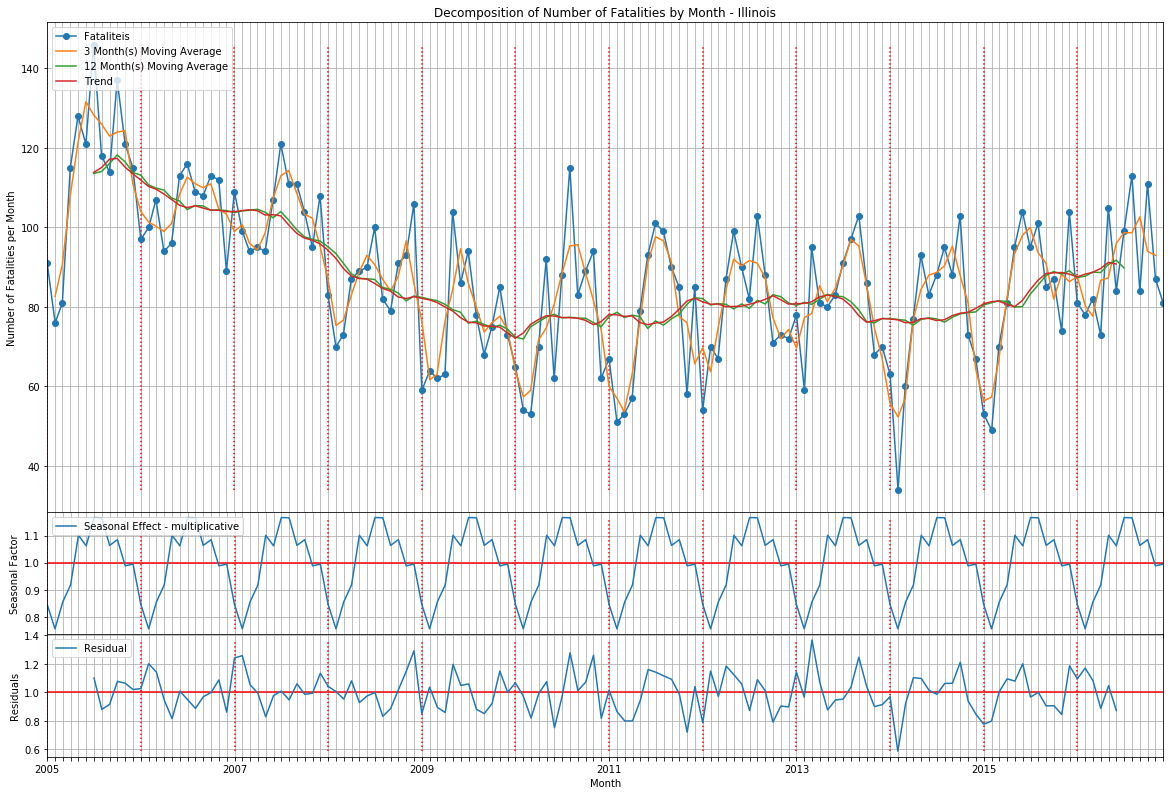

In [166]:
plt.figure(figsize=(20,15))
Model = 'multiplicative'
#Model = 'additive'
N = [3,12]
K_Crash_DF['Month'] = [d.strftime('%Y-%m') for d in K_Crash_DF.DATE]
df = pd.DataFrame(K_Crash_DF.groupby('Month')['K'].aggregate(sum).sort_index())
df.index = pd.to_datetime(df.index)
result = seasonal_decompose(df.K, model=Model)

plt.subplot2grid((6, 1), (0, 0), rowspan=4)
p1 = plt.plot(df,'-o',label='Fataliteis')
for i in range(2005,2018):
    plt.vlines(datetime(i,1,1,0,0),df.K.min(),df.K.max(),'red',':')
for n in N:
    df.K.rolling(window=n,center=True,min_periods=n).mean().plot(label='{} Month(s) Moving Average'.format(n))
result.trend.plot(label='Trend')
plt.xticks(list(df.index),[])
plt.xlabel('')
plt.ylabel('Number of Fatalities per Month')
plt.grid()
plt.title('Decomposition of Number of Fatalities by Month - Illinois')
plt.legend(loc='upper left',fancybox=True)

plt.subplot2grid((6, 1), (4, 0))
result.seasonal.plot(label='Seasonal Effect - {}'.format(Model))
for i in range(2005,2018):
    plt.vlines(datetime(i,1,1,0,0),result.seasonal.min(),result.seasonal.max(),'red',':')
plt.hlines(y={'additive':0,'multiplicative':1}[Model],colors='red',xmin=df.index.min(),xmax=df.index.max())
plt.xticks(list(df.index),[])
plt.xlabel('')
plt.ylabel('Seasonal Factor')
plt.grid()
plt.legend(loc='upper left',fancybox=True)

plt.subplot2grid((6, 1), (5, 0))
result.resid.plot(label='Residual')
for i in range(2005,2018):
    plt.vlines(datetime(i,1,1,0,0),result.resid.min(),result.resid.max(),'red',':')
plt.hlines(y={'additive':0,'multiplicative':1}[Model],colors='red',xmin=df.index.min(),xmax=df.index.max())
plt.xticks(df.index)
plt.ylabel('Residuals')
plt.legend(loc='upper left',fancybox=True)
plt.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('Decomposition.png',transparent=True,dpi=1200)

mdf = pd.DataFrame(result.seasonal.iloc[0:12])
mdf.columns = ['SeasonalFactor']
mdf.index = [d.strftime('%B') for d in mdf.index]
mdf = mdf.T
display(mdf)

plt.show()

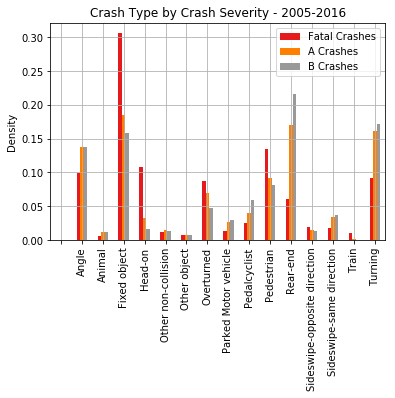

In [51]:
cdf = pd.DataFrame()
for n,df in zip(['Fatal Crashes','A Crashes','B Crashes'],[K_Crash_DF,A_Crash_DF,B_Crash_DF]):
    df1 = pd.DataFrame(df.CrashType.value_counts(True).sort_index())
    df1.columns = [n]
    cdf = pd.concat([cdf,df1],axis=1)
cdf.plot(kind='bar',colormap=plt.cm.Set1)
plt.title('Crash Type by Crash Severity - 2005-2016')
plt.grid()
plt.ylabel('Density')
plt.show()

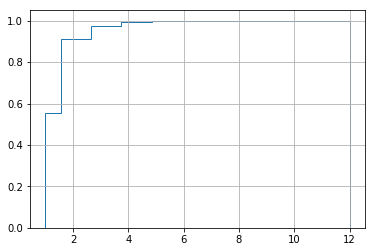

In [180]:
plt.hist(K_Crash_DF.NO_VEH,cumulative=True,density=True,histtype='step',bins=20)
plt.grid()
plt.show()

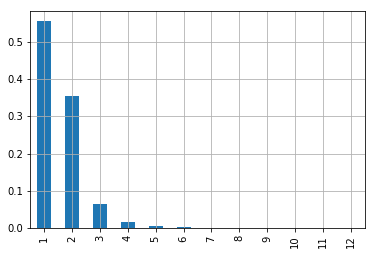

In [182]:
K_Crash_DF.NO_VEH.value_counts(True).sort_index().plot(kind='bar')
plt.grid()
plt.show()

In [91]:
# Hierarchical 
Cols = ['EA_RD','EA_IM','EA_UO','EA_SA']
for cols in [Cols[0:i] for i in range(1,len(Cols)+1)]:
    df = pd.DataFrame(K_Crash_DF.groupby(cols)['K'].aggregate(sum))
    #
    try:
        df['K_prc'] = df.groupby(level=list(range(0,len(cols)-1))).apply(lambda x: x / float(x.sum())).K
    except:
        df['K_prc'] = df.K/df.K.sum()
    display(df)
    

,K,K_prc
EA_RD,,
0,5902,0.468004
1,6709,0.531996


K     K_prc
EA_RD EA_IM                
0     0      4179  0.708065
      1      1723  0.291935
1     0      3051  0.454762
      1      3658  0.545238

K     K_prc
EA_RD EA_IM EA_UO                
0     0     0      3441  0.823403
            1       738  0.176597
      1     0      1153  0.669182
            1       570  0.330818
1     0     0      1878  0.615536
            1      1173  0.384464
      1     0      1763  0.481957
            1      1895  0.518043

K     K_prc
EA_RD EA_IM EA_UO EA_SA                
0     0     0     0      2961  0.860506
                  1       480  0.139494
            1     0       579  0.784553
                  1       159  0.215447
      1     0     0       921  0.798786
                  1       232  0.201214
            1     0       413  0.724561
                  1       157  0.275439
1     0     0     0      1414  0.752929
                  1       464  0.247071
            1     0       823  0.701620
                  1       350  0.298380
      1     0     0      1251  0.709586
                  1       512  0.290414
            1     0      1331  0.702375
                  1       564  0.297625